In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO EXPERIMENTO ---
np.random.seed(42)
n_samples = 3000
order = 4 # M=4 (5 taps)

# Entrada: Ruído Branco Complexo (Cenário ideal para o LMS)
x = (np.random.randn(n_samples) + 1j * np.random.randn(n_samples)) / np.sqrt(2)

# Planta Desconhecida (Sistema FIR)
w_true = np.array([0.5 + 0.1j, -0.3 + 0.4j, 0.1 - 0.2j, 0.4 + 0.3j, -0.1 + 0.1j])
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
d = d_clean + 0.05 * (np.random.randn(n_samples) + 1j * np.random.randn(n_samples))

In [3]:
# --- 2. EXECUÇÃO DO LMS ---
# step_size (mu): Define a velocidade e a estabilidade.
# Para estabilidade: 0 < mu < 2 / (M+1 * pot_entrada)
filt_lms = pdf.LMS(
    filter_order=order,
    step_size=0.02
)

result = filt_lms.optimize(x, d, verbose=True)

[LMS] Completed in 9.551 ms


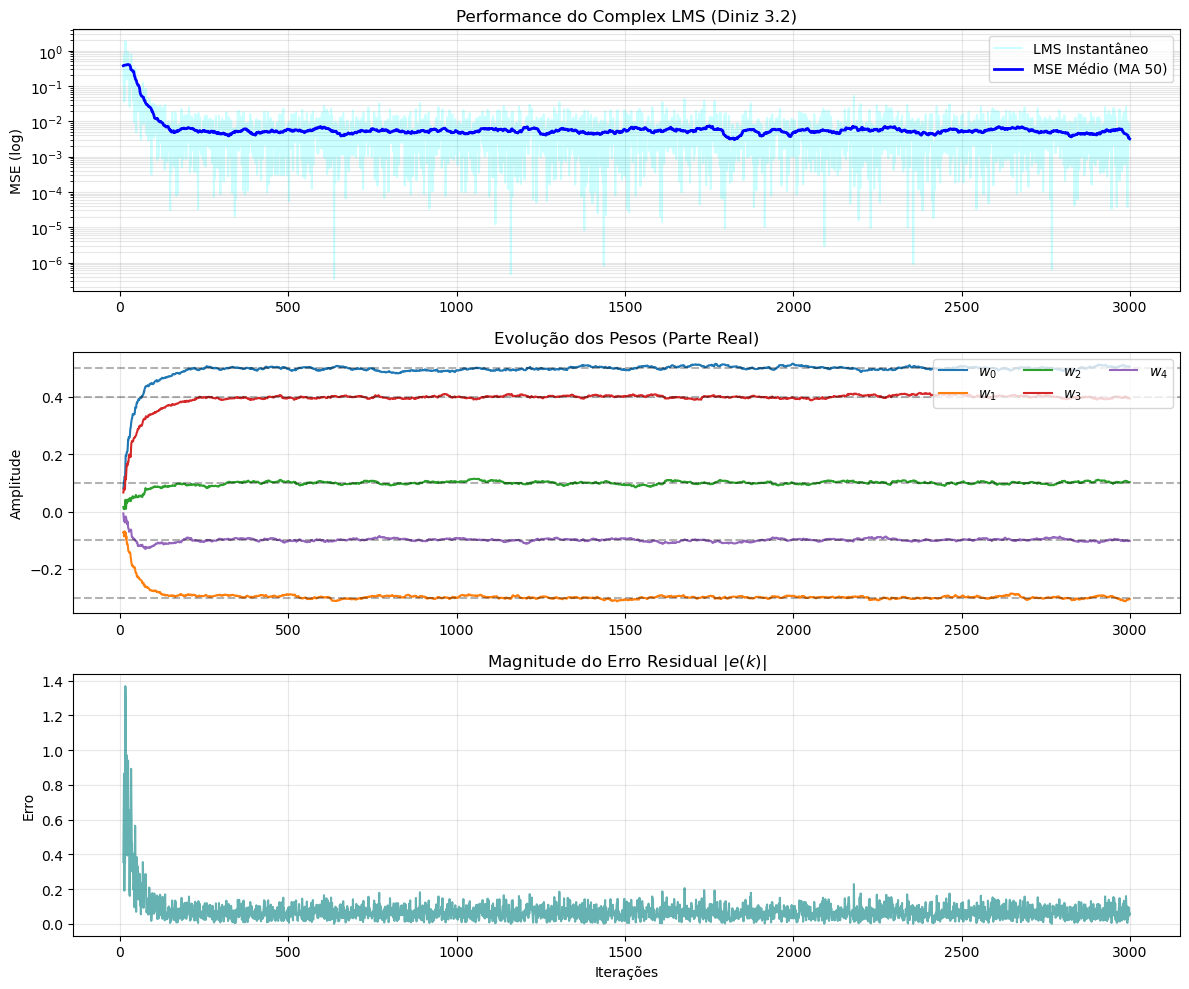

Desvio Final (Norma): 1.103869


In [4]:
# --- 3. ANÁLISE VISUAL ---
offset = 10
mse = result.mse()
coeffs_history = result.coefficients[1:] 
t = np.arange(len(mse))

plt.figure(figsize=(12, 10))

# Subplot 1: Curva de Aprendizado (MSE)
plt.subplot(3, 1, 1)
plt.semilogy(t[offset:], mse[offset:], label='LMS Instantâneo', alpha=0.2, color='cyan')
mse_smooth = np.convolve(mse, np.ones(50)/50, mode='same')
plt.semilogy(t[offset:], mse_smooth[offset:], label='MSE Médio (MA 50)', color='blue', lw=2)
plt.title('Performance do Complex LMS (Diniz 3.2)')
plt.ylabel('MSE (log)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 2: Trajetória dos Coeficientes (Parte Real)
plt.subplot(3, 1, 2)
for i in range(coeffs_history.shape[1]):
    plt.plot(t[offset:], np.real(coeffs_history[offset:, i]), label=f'$w_{i}$')
    plt.axhline(y=np.real(w_true[i]), color='black', linestyle='--', alpha=0.3)
plt.title('Evolução dos Pesos (Parte Real)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', ncol=3)

# Subplot 3: Magnitude do Erro
plt.subplot(3, 1, 3)
plt.plot(t[offset:], np.abs(result.errors[offset:]), color='teal', alpha=0.6)
plt.title('Magnitude do Erro Residual $|e(k)|$')
plt.xlabel('Iterações')
plt.ylabel('Erro')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Desvio Final (Norma): {np.linalg.norm(coeffs_history[-1] - w_true):.6f}")